# Lab Assignment Six: CNNs
### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng
### 1. Preparation
#### 1.1 Metrics


We choose F1-score to evaluate our algorithm's performance. F1-score combines precision and recall into a single metric, providing a balanced assessment of the model's performance. 

In many real-world scenarios, the distribution of classes in the dataset might not be uniform. Accuracy alone can be misleading in such cases. F1-Score, being the harmonic mean of precision and recall, is less affected by class imbalance compared to accuracy. It provides a balanced assessment of the model's performance across different classes.

Depending on the specific application, false positives and false negatives might have different consequences. F1-Score considers both precision and recall, which allows for a balanced evaluation of false positives and false negatives.

F1-Score is easy to interpret and communicate, especially when compared to more complex metrics like AUC-ROC (Area Under the Receiver Operating Characteristic Curve). Its intuitive nature makes it a preferred choice for reporting model performance to stakeholders who might not have a technical background.

Overall, F1-score is well-suited for our car image classification tasks where achieving high precision and recall simultaneously is desirable. By optimizing for F1 score, we ensure a balance between false positives and false negatives, thus enhancing the overall effectiveness and reliability of the model's predictions.

#### 1.2 Dividing Data


We will use stratified 5-Fold Cross-Validation as it ensures that each fold preserves the percentage of samples for each class. This is crucial, especially when dealing with imbalanced datasets where some classes might be significantly underrepresented. By maintaining the class distribution in each fold, we obtain more reliable estimates of model performance across different subsets of data. 

By training the model on multiple different subsets of the data and evaluating its performance on multiple corresponding test sets, Stratified K-Fold Cross-Validation provides a more realistic estimate of how well the model will generalize to unseen data in practice. This mirrors real-world scenarios where the model needs to perform well on diverse data distributions.

stratified K-Fold Cross-Validation in general provides a more robust estimate of model performance compared to a single train-test split. It reduces the risk of overfitting to a particular training set or being overly sensitive to the random assignment of samples to the training and testing sets.

Since the dataset we choosen is computational expansive for our models, we choose 5 folds instead of 10 folds.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)

images, labels = [], []
UNIFORMED_SIZE = (64,64)



# load and resize images
for image_path in Path('..\LabAssignment2\data').rglob('*.jpg'):
    class_name = image_path.parent.stem
    train_test = image_path.parent.parent.stem
    img = cv2.resize(cv2.imread(str(image_path)), UNIFORMED_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    labels.append(class_name)

# concatenate to two ndarrays
images_np = np.concatenate([images])
labels_np = np.concatenate([labels])

# scale image to 0-1
images_np = images_np / 255

# encode string lables to numeric labels
encoder = LabelEncoder()
labels_np = encoder.fit_transform(labels_np)
print(f"Images: {images_np.shape}, Labels: {labels_np.shape}")

Images: (4165, 64, 64, 3), Labels: (4165,)


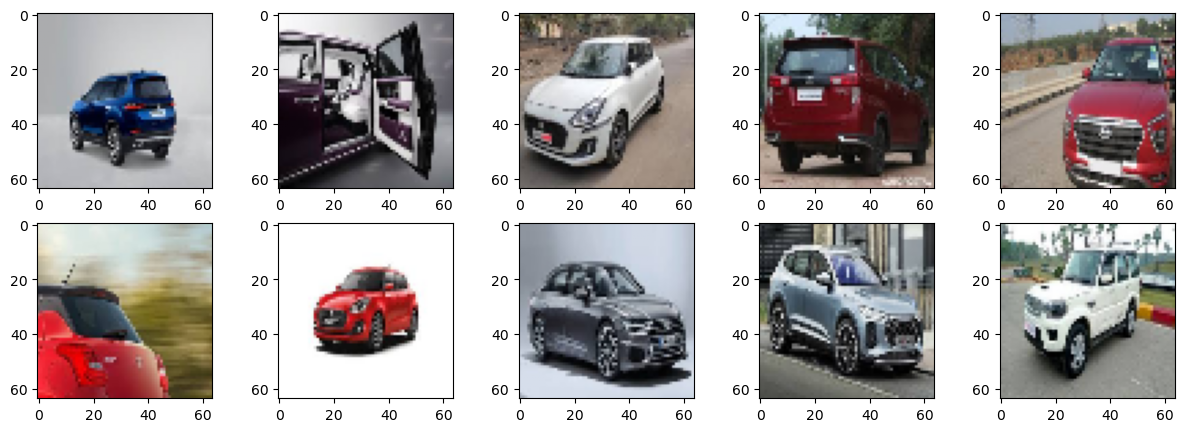

In [2]:
# dataset visualization
plt.figure(figsize=(15, 5))
for i, r_idx in enumerate(np.random.randint(0, images_np.shape[0], 10)):
    ax = plt.subplot(2,5,i+1)
    ax.imshow(images_np[r_idx])

In [3]:
# stratified 5-Fold Cross-Validation
from sklearn.model_selection import StratifiedKFold

n_splits = 5
shuffle_splitter = StratifiedKFold(n_splits=n_splits)

# Iterate over splits
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]
    print(f"Split {fold+1} - Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Split 1 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)
Split 2 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)
Split 3 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)
Split 4 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)
Split 5 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)


### 2. Modeling
#### 2.1 Data Expansion (Augmentation)

In [4]:
from keras.utils import to_categorical

num_classes = len(set(y_train))
print("Number of classes:", num_classes)

y_train_ohe = to_categorical(y_train, num_classes=num_classes)

y_test_ohe = to_categorical(y_test, num_classes=num_classes)

print(f"Y train shape: {y_train_ohe.shape}, Y test shape: {y_test_ohe.shape}")

Number of classes: 7
Y train shape: (3332, 7), Y test shape: (833, 7)


The y_train and y_test have been one hot encoded to have 7 classes for multiclassification. 

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import plot_model, to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score


print(f"system keras Version: {keras.__version__}")

system keras Version: 3.2.1


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0.2, # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.1,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None
)

datagen.fit(X_train)

The chosen data expansion techniques aptly simulate real-world variations in object orientation, position, perspective, and appearance, bolstering the dataset's resilience and its capacity for generalization. By introducing diverse transformations such as rotation, shifting, shearing, and flipping, the model becomes adept at recognizing objects across a spectrum of conditions. Moreover, the inclusion of a customized preprocessing function further diversifies the dataset by introducing variations in color, noise, and image structure, fostering the model's ability to discern essential features amidst variability.

### 2.2 CNN 

The two CNNs architectures we will utilize are AlexNet and Ensemble Nets. 

#### 2.2.1 AlexNet

In [7]:
# example training code
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import plot_model, to_categorical

alexnet = Sequential(name='alexnet')

alexnet.add(Conv2D(filters=32,
                   input_shape = (64,64,3),
                   kernel_size= (3,3),
                   padding='same',
                   activation='relu',
                   data_format='channels_last'))

alexnet.add(Conv2D(filters=64,
                    kernel_size=(3,3),
                    padding='same',
                    activation='relu'))
alexnet.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

alexnet.add(Conv2D(filters=128,
                    kernel_size=(5,5),
                    padding='same',
                    activation='relu'))
alexnet.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

alexnet.add(Dropout(0.25))
alexnet.add(Flatten())
alexnet.add(Dense(128, activation='relu'))
alexnet.add(Dropout(0.5))
alexnet.add(Dense(num_classes, activation='softmax'))

alexnet.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['F1Score'])

alexnet.summary()

/Users/48923269/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "alexnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,419,655 (16.86 MB)

 Trainable params: 4,419,655 (16.86 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
alexnet_list = []
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]

    # Update y_train_ohe and y_test_ohe
    y_train_ohe = to_categorical(y_train, num_classes=num_classes)
    y_test_ohe = to_categorical(y_test, num_classes=num_classes)
    
    alexnet_history = alexnet.fit(X_train, y_train_ohe, 
                           batch_size=512, 
                           epochs=10, 
                           shuffle=True, 
                           verbose=1,
                           validation_data=(X_test, y_test_ohe),
                           callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
    
    # Append the history object to the list
    alexnet_list.append(alexnet_history)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - F1Score: 0.1260 - loss: 4.0068 - val_F1Score: 0.0828 - val_loss: 1.9339
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - F1Score: 0.0824 - loss: 1.9176 - val_F1Score: 0.0701 - val_loss: 1.8645
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - F1Score: 0.1189 - loss: 1.8682 - val_F1Score: 0.1175 - val_loss: 1.8241
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - F1Score: 0.1491 - loss: 1.8328 - val_F1Score: 0.1410 - val_loss: 1.8224
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - F1Score: 0.1771 - loss: 1.7986 - val_F1Score: 0.2048 - val_loss: 1.7597
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - F1Score: 0.2135 - loss: 1.7720 - val_F1Score: 0.2459 - val_loss: 1.6847
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - F1Score: 0.2281 - loss: 1.7273 - val_F1Score: 0.2198 - val_loss: 1.6818
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - F1Score: 0.2447 - loss: 1.7277 - val_F1Score: 0.2300 - val_loss: 1.6482
Epoch 9/10
7/7 ━━━━━━━━━

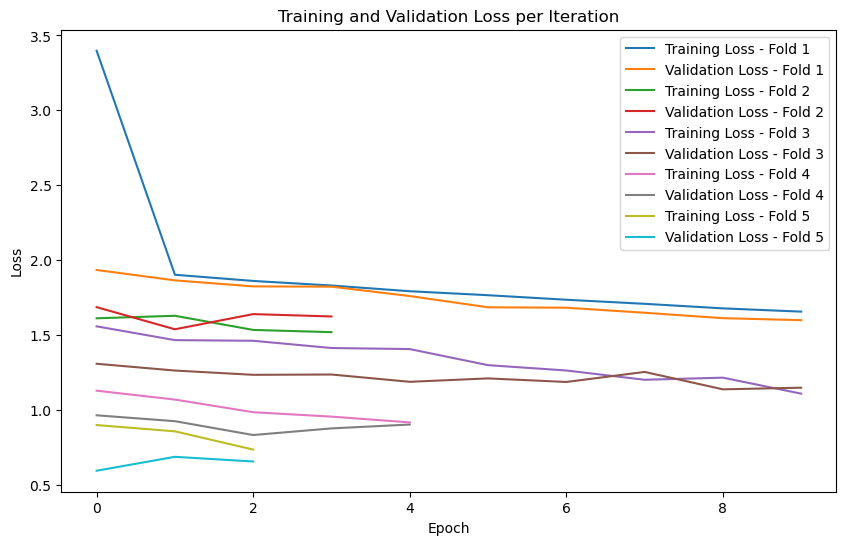

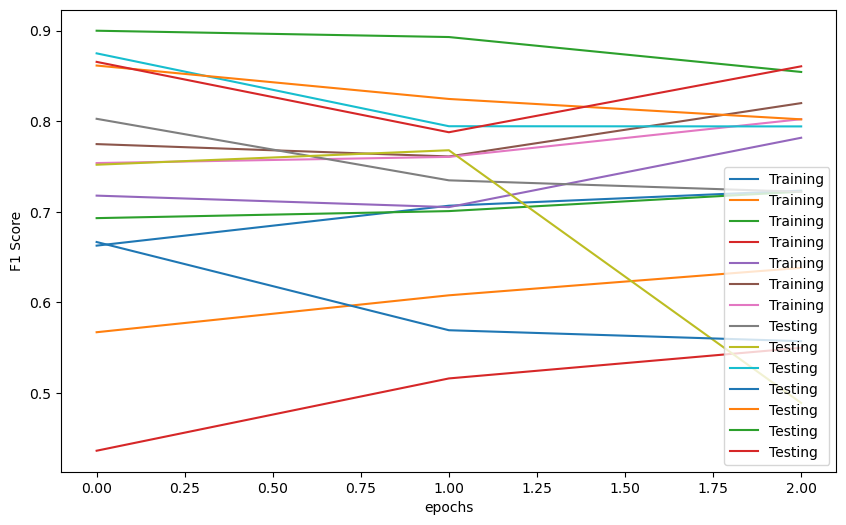

In [14]:
plt.figure(figsize=(10, 6))

for fold, history in enumerate(alexnet_list):
    plt.plot(history.history['loss'], label=f'Training Loss - Fold {fold+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Fold {fold+1}')

plt.title('Training and Validation Loss per Iteration')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(alexnet_list[-1].history['F1Score'], label='Training')
plt.plot(alexnet_list[-1].history['val_F1Score'], label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.show()

#### 2.2.2 AlexNet with increased kernels and adam optimizer.

In [10]:
# example training code
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import plot_model, to_categorical

alexnet_1 = Sequential(name='alexnet_modified')

alexnet_1.add(Conv2D(filters=32,
                   input_shape = (64,64,3),
                   kernel_size= (5,5),
                   padding='same',
                   activation='relu',
                   data_format='channels_last'))

alexnet_1.add(Conv2D(filters=64,
                    kernel_size=(5,5),
                    padding='same',
                    activation='relu'))
alexnet_1.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

alexnet_1.add(Conv2D(filters=128,
                    kernel_size=(7,7),
                    padding='same',
                    activation='relu'))
alexnet_1.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

alexnet_1.add(Dropout(0.25))
alexnet_1.add(Flatten())
alexnet_1.add(Dense(128, activation='relu'))
alexnet_1.add(Dropout(0.5))
alexnet_1.add(Dense(num_classes, activation='softmax'))

alexnet_1.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['F1Score'])

alexnet_1.summary()

/Users/48923269/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "alexnet_modified"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,650,567 (17.74 MB)

 Trainable params: 4,650,567 (17.74 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
alexnet_mod_list = []
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]

     # Update y_train_ohe and y_test_ohe
    y_train_ohe = to_categorical(y_train, num_classes=num_classes)
    y_test_ohe = to_categorical(y_test, num_classes=num_classes)
    
    alexnet_mod_history = alexnet_1.fit(X_train, y_train_ohe, 
                           batch_size=512, 
                           epochs=10, 
                           shuffle=True, 
                           verbose=1,
                           validation_data=(X_test, y_test_ohe),
                           callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    
    # Append the history object to the list
    alexnet_mod_list.append(alexnet_mod_history)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - F1Score: 0.1199 - loss: 2.3242 - val_F1Score: 0.0553 - val_loss: 1.8996
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - F1Score: 0.0891 - loss: 1.8975 - val_F1Score: 0.0558 - val_loss: 1.8852
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - F1Score: 0.0921 - loss: 1.8799 - val_F1Score: 0.1013 - val_loss: 1.8649
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - F1Score: 0.0986 - loss: 1.8671 - val_F1Score: 0.1531 - val_loss: 1.8457
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - F1Score: 0.1457 - loss: 1.8460 - val_F1Score: 0.1705 - val_loss: 1.7941
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - F1Score: 0.1663 - loss: 1.8051 - val_F1Score: 0.2015 - val_loss: 1.7538
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - F1Score: 0.2030 - loss: 1.7605 - val_F1Score: 0.2327 - val_loss: 1.6745
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - F1Score: 0.2169 - loss: 1.7260 - val_F1Score: 0.2200 - val_loss: 1.7040
Epoch 9/10
7/7 ━━━━━━━━━

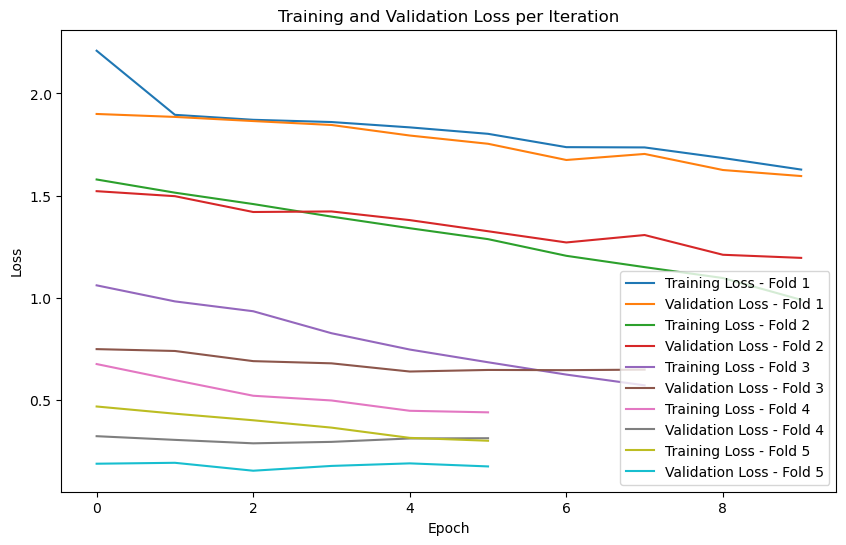

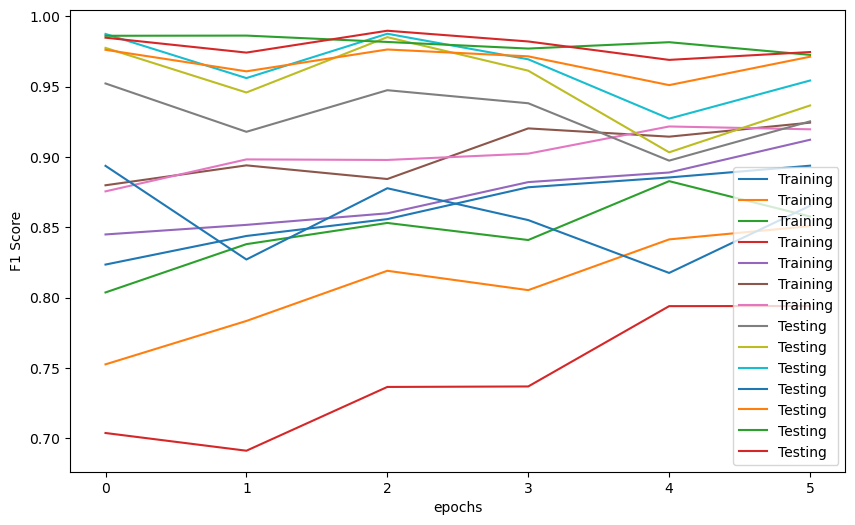

In [13]:
plt.figure(figsize=(10, 6))

for fold, history in enumerate(alexnet_mod_list):
    plt.plot(history.history['loss'], label=f'Training Loss - Fold {fold+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Fold {fold+1}')

plt.title('Training and Validation Loss per Iteration')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(alexnet_mod_list[-1].history['F1Score'], label='Training')
plt.plot(alexnet_mod_list[-1].history['val_F1Score'], label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.show()

#### 2.2.3 Ensemble Net

In [15]:
from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

num_ensembles = 3
l2_lambda = 0.000001
img_wh = 64

input_holder = Input(shape=(img_wh, img_wh, 3))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(num_classes, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(num_classes, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder,outputs=x)

cnn_ens.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['F1Score'])

cnn_ens.summary()

/Users/48923269/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │      9,248 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │      9,248 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │      9,248 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │      1,056 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │      1,056 │ conv2d_12[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │      1,056 │ conv2d_16[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 16, 16,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │      4,160 │ conv2d_10[0][0] 

 Total params: 897,167 (3.42 MB)

 Trainable params: 897,167 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
cnnens_list = []
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]

     # Update y_train_ohe and y_test_ohe
    y_train_ohe = to_categorical(y_train, num_classes=num_classes)
    y_test_ohe = to_categorical(y_test, num_classes=num_classes)
    
    cnnens_history = cnn_ens.fit(X_train, y_train_ohe, 
                           batch_size=512, 
                           epochs=10, 
                           shuffle=True, 
                           verbose=1,
                           validation_data=(X_test, y_test_ohe),
                           callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    
    # Append the history object to the list
    cnnens_list.append(cnnens_history)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - F1Score: 0.1038 - loss: 3.9015 - val_F1Score: 0.0556 - val_loss: 1.9460
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - F1Score: 0.0795 - loss: 1.9455 - val_F1Score: 0.0706 - val_loss: 1.9445
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - F1Score: 0.0812 - loss: 1.9383 - val_F1Score: 0.0582 - val_loss: 1.9424
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - F1Score: 0.0705 - loss: 1.9404 - val_F1Score: 0.0558 - val_loss: 1.9403
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - F1Score: 0.0572 - loss: 1.9398 - val_F1Score: 0.0666 - val_loss: 1.9369
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - F1Score: 0.0728 - loss: 1.9356 - val_F1Score: 0.0557 - val_loss: 1.9364
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - F1Score: 0.0822 - loss: 1.9259 - val_F1Score: 0.1083 - val_loss: 1.9115
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - F1Score: 0.1119 - loss: 1.8951 - val_F1Score: 0.1091 - val_loss: 1.8981
Epoch 9/10
7/7 ━━━━━━━━━

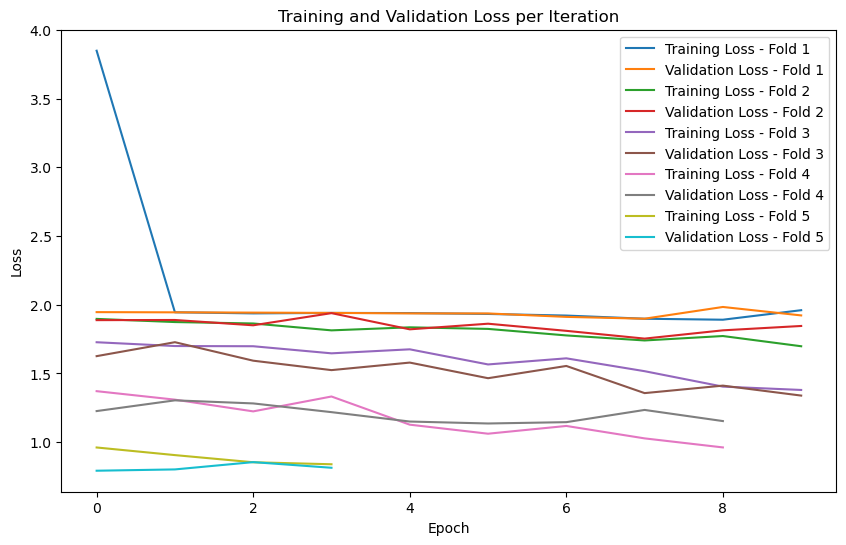

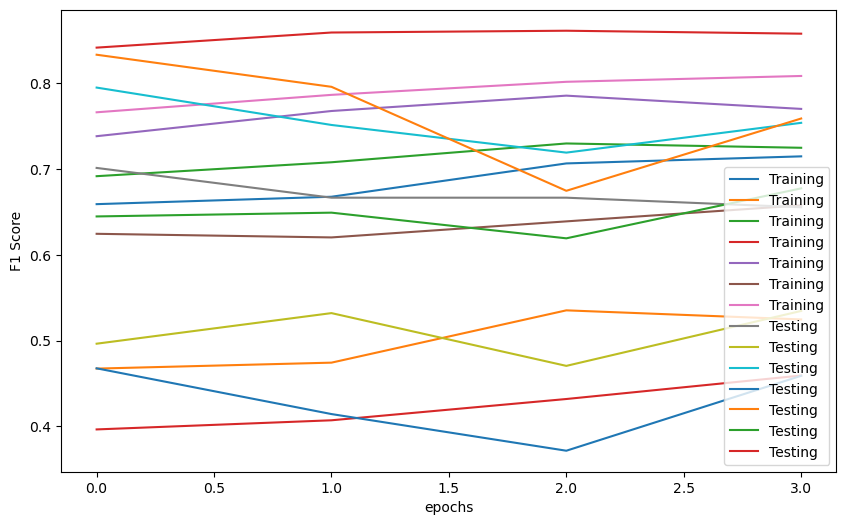

In [18]:
plt.figure(figsize=(10, 6))

for fold, history in enumerate(cnnens_list):
    plt.plot(history.history['loss'], label=f'Training Loss - Fold {fold+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Fold {fold+1}')

plt.title('Training and Validation Loss per Iteration')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(cnnens_list[-1].history['F1Score'],label='Training')
plt.plot(cnnens_list[-1].history['val_F1Score'],label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.show()

#### 2.2.4 Ensemble Net with increased filters

In [19]:
num_ensembles = 3
l2_lambda = 0.000001
img_wh = 64

input_holder = Input(shape=(img_wh, img_wh, 3))

# start with a conv layer
x = Conv2D(filters=64,
               input_shape = (img_wh,img_wh,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=128,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=128,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(num_classes, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(num_classes, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens_1 = Model(inputs=input_holder,outputs=x)

cnn_ens_1.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['F1Score'])

cnn_ens_1.summary()

/Users/48923269/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_20[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │     36,928 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │     36,928 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │     36,928 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │      4,160 │ conv2d_22[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │      4,160 │ conv2d_26[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 32,    │      4,160 │ conv2d_30[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 16, 16,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     16,512 │ conv2d_24[0][0] 

 Total params: 3,582,063 (13.66 MB)

 Trainable params: 3,582,063 (13.66 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
cnnens_mod_list = []
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]

    # Update y_train_ohe and y_test_ohe
    y_train_ohe = to_categorical(y_train, num_classes=num_classes)
    y_test_ohe = to_categorical(y_test, num_classes=num_classes)
    
    cnnens_mod_history = cnn_ens_1.fit(X_train, y_train_ohe, 
                           batch_size=512, 
                           epochs=10, 
                           shuffle=True, 
                           verbose=1,
                           validation_data=(X_test, y_test_ohe),
                           callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    
    # Append the history object to the list
    cnnens_mod_list.append(cnnens_mod_history)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - F1Score: 0.1035 - loss: 20.5655 - val_F1Score: 0.0323 - val_loss: 1.9495
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - F1Score: 0.0312 - loss: 1.9492 - val_F1Score: 0.0323 - val_loss: 1.9480
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - F1Score: 0.0430 - loss: 1.9477 - val_F1Score: 0.0558 - val_loss: 1.9463
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - F1Score: 0.0552 - loss: 1.9459 - val_F1Score: 0.0558 - val_loss: 1.9443
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - F1Score: 0.0753 - loss: 1.9437 - val_F1Score: 0.0558 - val_loss: 1.9423
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - F1Score: 0.0785 - loss: 1.9414 - val_F1Score: 0.0558 - val_loss: 1.9401
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - F1Score: 0.0566 - loss: 1.9398 - val_F1Score: 0.0558 - val_loss: 1.9379
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - F1Score: 0.0567 - loss: 1.9373 - val_F1Score: 0.0558 - val_loss: 1.9356
Epoch 9/10
7/7 ━━━━━━━━

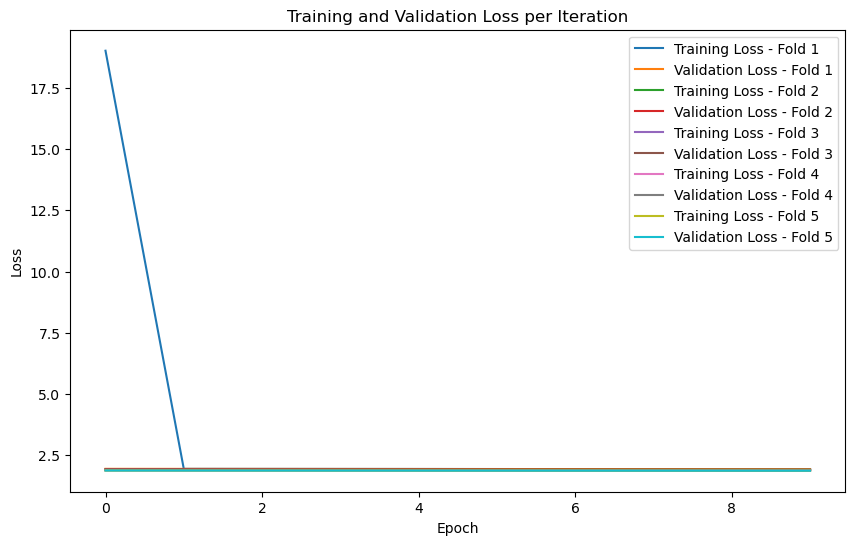

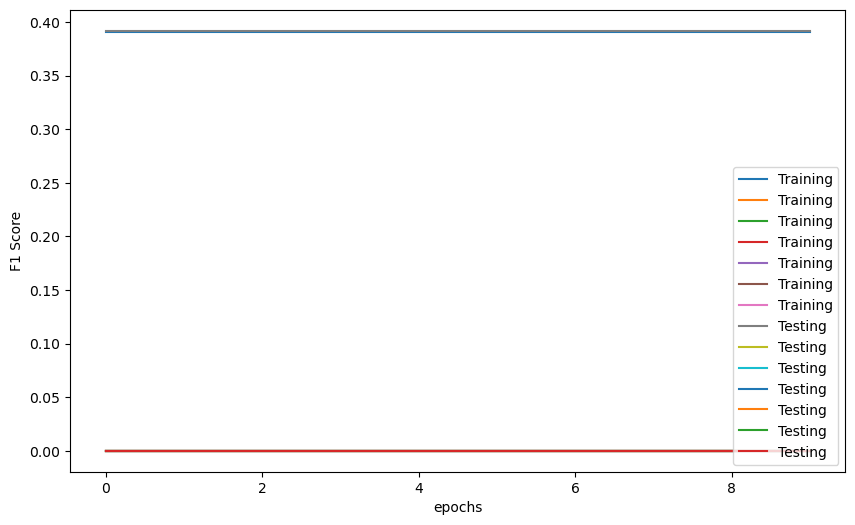

In [21]:
plt.figure(figsize=(10, 6))

for fold, history in enumerate(cnnens_mod_list):
    plt.plot(history.history['loss'], label=f'Training Loss - Fold {fold+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Fold {fold+1}')

plt.title('Training and Validation Loss per Iteration')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(cnnens_mod_list[-1].history['F1Score'],label='Training')
plt.plot(cnnens_mod_list[-1].history['val_F1Score'],label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.show()

#### 2.3 Visualize and Compare the Performance

##### 2.3.1 Visualize results of all the CNNs

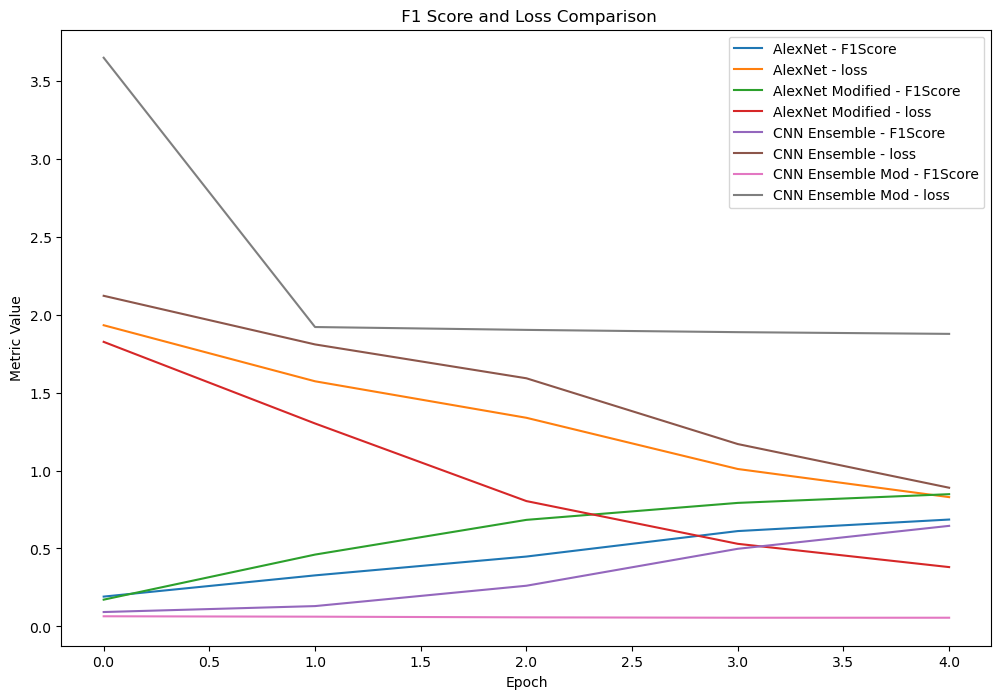

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


def extract_performance_metrics(histories):
    
    mean_f1_scores = np.mean([history.history['F1Score'][-1]
                             for history in histories])  # Assuming the last epoch's score
    mean_losses = np.mean([h.history['loss'][-1] for h in histories])
    return mean_f1_scores, mean_losses

alexnet_f1, alexnet_loss = extract_performance_metrics(alexnet_list)
alexnet_1_f1, alexnet_1_loss = extract_performance_metrics(alexnet_mod_list)
cnn_ens_f1, cnn_ens_loss = extract_performance_metrics(cnnens_list)
cnn_ens_1_f1, cnn_ens_1_loss = extract_performance_metrics(cnnens_mod_list)


def plot_metrics(models, metrics, title):
    plt.figure(figsize=(12, 8))
    for model_name, model_histories in models.items():
        for metric in metrics:
            means = [np.mean(history.history.get(metric, [0])) for history in model_histories]
            plt.plot(means, label=f'{model_name} - {metric}')

    plt.title(title)
    plt.ylabel('Metric Value')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
# Define your models and their histories
model_histories = {
    'AlexNet': alexnet_list,
    'AlexNet Modified': alexnet_mod_list,
    'CNN Ensemble': cnnens_list,
    'CNN Ensemble Mod': cnnens_mod_list
}

# Plot F1 Scores and Losses
plot_metrics(model_histories, ['F1Score', 'loss'],
             ' F1 Score and Loss Comparison')

##### 2.3.2 Compare the performance using Confusion Matrix

In [71]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

def compare_models(alexnet, alexnet_1, cnn_ens, cnn_ens_1, X_test, y_test, labels='auto'):
    models = [alexnet, alexnet_1, cnn_ens, cnn_ens_1]
    model_names = ['Alexnet', 'Alexnet_1', 'CNN Ensemble', 'CNN Ensemble_1']
    results = {}
    plt.figure(figsize=(20,10))

    for idx, model in enumerate(models):
        if model is not None:
            yhat = np.argmax(model.predict(X_test), axis=1)
            f1_score = mt.f1_score(y_test, yhat, average='weighted')
            results[model_names[idx]] = f1_score
            
            plt.subplot(2, 2, idx + 1)
            cm = mt.confusion_matrix(y_test, yhat)
            cm_normalized = cm / np.sum(cm, axis=1, keepdims=True)
            sns.heatmap(cm_normalized, annot=True, fmt='.4f', xticklabels=labels, yticklabels=labels)
            plt.title(f'{model_names[idx]}: {f1_score:.4f}')

    plt.tight_layout()
    plt.show()
    return results


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


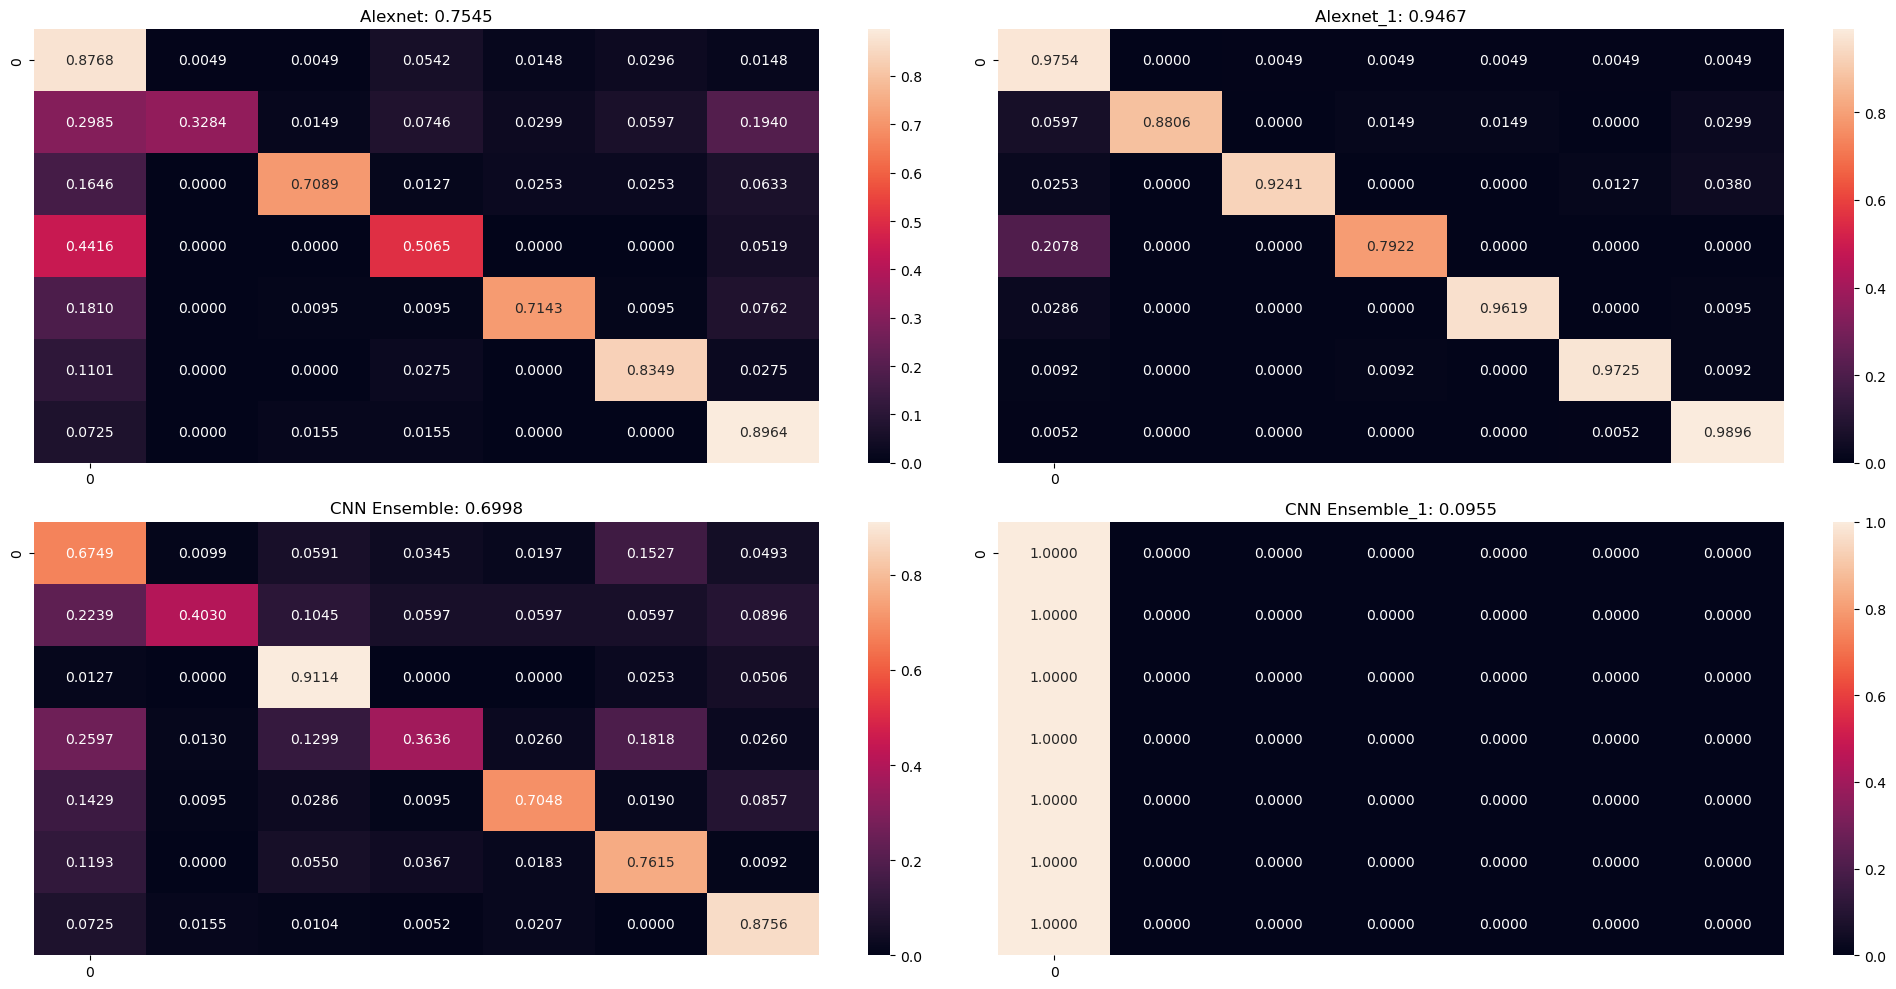

{'Alexnet': 0.754466675780598,
 'Alexnet_1': 0.9467297485008194,
 'CNN Ensemble': 0.6997684710430921,
 'CNN Ensemble_1': 0.09550306609130138}

In [72]:
compare_models(alexnet, alexnet_1, cnn_ens, cnn_ens_1, X_test, y_test, num_classes)

From above the result, the model 1- AlexNet with the modified parameters had the best performance with highest F1 Score.
- In the next steps, we will use parameters from the CNN model with best performance to build a standard MLP then compare the CNN to MLP.

#### 2.4 Compare Convolutional Network to a Standard Multi-Layer Perceptron (MLP)
- Number of Units and Activation Functions: The model uses 128 units in the final dense layer before the output layer. We'll use a similar approach in the MLP.
- Dropout Rates: The model applies dropout rates of 0.25 and 0.5 at different stages. We'll align the MLP to use similar dropout configurations.
- Optimizer: Both models will use 'adam', which is consistent with what set for AlexNet_1.

##### 2.4.1 Define and Train the MLP

In [73]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

def build_mlp(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (64, 64, 3)

# Initialize the MLP model
mlp_model = build_mlp(input_shape, num_classes)
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['F1Score'])

mlp_model.summary()

/Users/48923269/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_22 (Flatten)            │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,590,407 (6.07 MB)

 Trainable params: 1,590,407 (6.07 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Train the model using cross-validation
    
mlp_history_list = []
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]

    # Update y_train_ohe and y_test_ohe
    y_train_ohe = to_categorical(y_train, num_classes=num_classes)
    y_test_ohe = to_categorical(y_test, num_classes=num_classes)

    mlp_history = mlp_model.fit(X_train, y_train_ohe,
                                       batch_size=512,
                                       epochs=10,
                                       shuffle=True,
                                       verbose=1,
                                       validation_data=(X_test, y_test_ohe),
                                       callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

    # Append the history object to the list
    mlp_history_list.append(mlp_history)
    

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - F1Score: 0.0790 - loss: 1.8555 - val_F1Score: 0.0584 - val_loss: 1.8543
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - F1Score: 0.0803 - loss: 1.8554 - val_F1Score: 0.0584 - val_loss: 1.8543
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - F1Score: 0.0800 - loss: 1.8538 - val_F1Score: 0.0584 - val_loss: 1.8543
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - F1Score: 0.0848 - loss: 1.8542 - val_F1Score: 0.0584 - val_loss: 1.8543
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - F1Score: 0.0839 - loss: 1.8623 - val_F1Score: 0.0584 - val_loss: 1.8543
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - F1Score: 0.0790 - loss: 1.8619 - val_F1Score: 0.0610 - val_loss: 1.8524
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - F1Score: 0.0776 - loss: 1.8526 - val_F1Score: 0.0610 - val_loss: 1.8524
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - F1Score: 0.0787 - loss: 1.8600 - val_F1Score: 0.0610 - val_loss: 1.8524
Epoch 4/10
7/7 ━

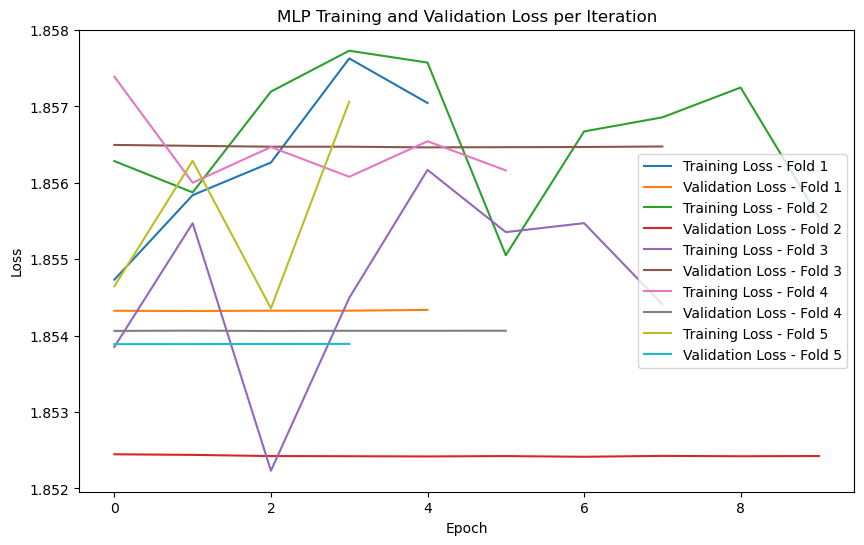

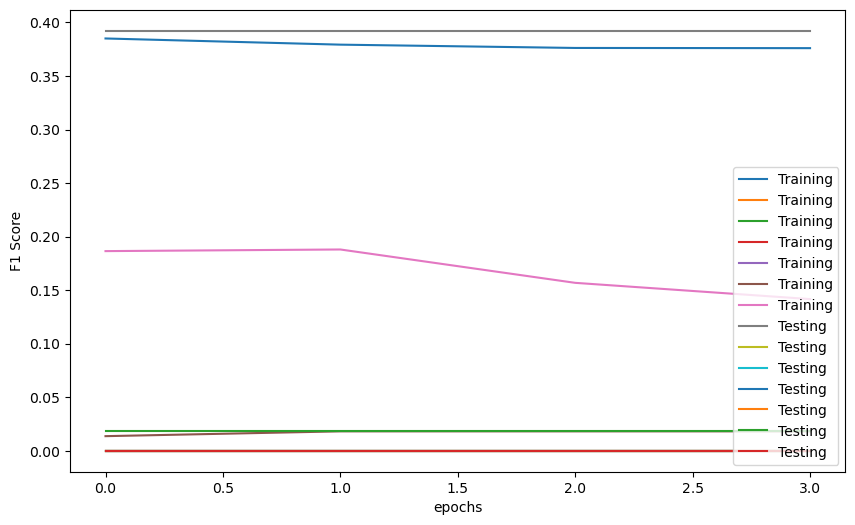

In [89]:
plt.figure(figsize=(10, 6))
for fold, history in enumerate(mlp_history_list):
    plt.plot(history.history['loss'], label=f'Training Loss - Fold {fold+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Fold {fold+1}')

plt.title('MLP Training and Validation Loss per Iteration')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(mlp_history_list[-1].history['F1Score'], label='Training')
plt.plot(mlp_history_list[-1].history['val_F1Score'], label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.show()

##### 2.4.2 Compare the performances using the receiver operating characteristic and the area under the curve

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, f1_score
from tensorflow.keras.utils import to_categorical


def plot_roc_curve(models, model_names, X_test, y_test, num_classes):
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])

    # Check if y_test is one-hot encoded and convert if necessary
    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    for model, color, model_name in zip(models, colors, model_names):
        if not hasattr(model, 'predict'):
            raise ValueError(
                f"The model {model_name} does not support predict method.")

        y_pred_prob = model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_test_binary = to_categorical(y_test, num_classes=num_classes)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        f1_scores = []

        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(
                y_test_binary[:, i], y_pred_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(
            y_test_binary.ravel(), y_pred_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.plot(fpr["micro"], tpr["micro"], color=color,
                 label=f'ROC curve of {model_name} (area = {roc_auc["micro"]:.4f})')

        avg_auc = np.mean([roc_auc[i] for i in range(num_classes)])
        avg_f1 = np.mean(f1_scores)
        print(
            f'{model_name} - Average AUC Score: {avg_auc:.4f}, Average F1 Score: {avg_f1:.4f}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-average ROC curve')
    plt.legend(loc="lower right")
    plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step
AlexNet - Average AUC Score: 0.9981, Average F1 Score: 0.9467
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MLP - Average AUC Score: 0.5019, Average F1 Score: 0.0980


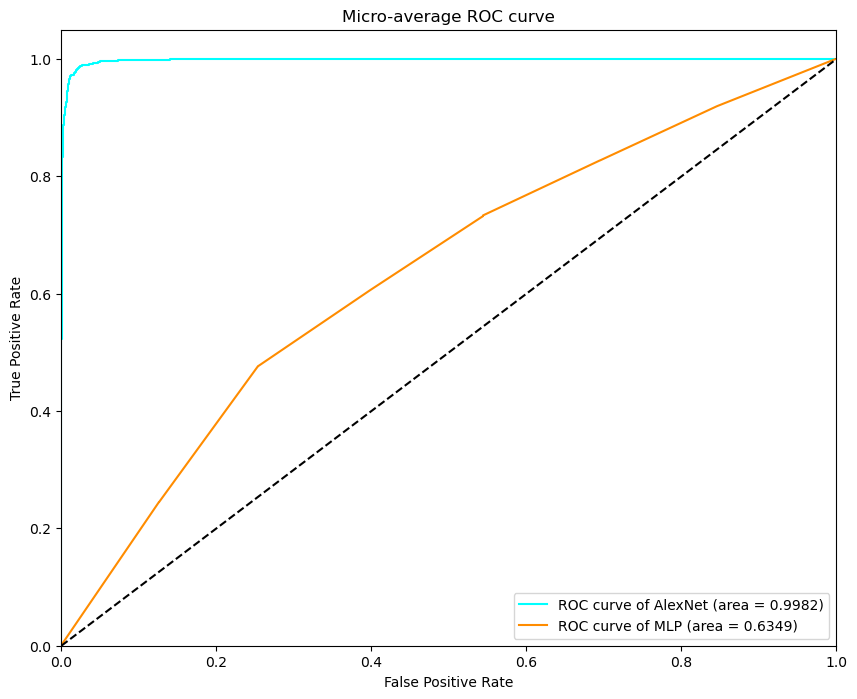

In [91]:
models = [alexnet_1, mlp_model]
model_names = ['AlexNet', 'MLP']
plot_roc_curve(models, model_names, X_test, y_test, num_classes)

For results presented from above performance, a standard Multi-Layer Perceptron (MLP) is showing significantly lower performance on an image dataset, as indicated by much lower ROC values and extremely low F1 scores, it suggests several potential issues and necessitates certain recommendations in future research:
1.	Inadequacy of MLP for Image Data: MLPs, being fully connected networks, are generally less suited for image data compared to convolutional neural networks (CNNs). This is due to the MLP's inability to capture the spatial and hierarchical patterns in image data effectively.
2.	Feature Extraction: Unlike CNNs, MLPs do not inherently extract features from images. Therefore, it might be beneficial to manually extract features or use pre-trained models to preprocess the data before feeding it into the MLP.
3.	Network Architecture Adjustments: Adjusting the architecture of the MLP might help, such as increasing the number of hidden layers or the number of neurons per layer, although this can lead to increased computational cost and risk of overfitting.

In summary, if the MLP is performing poorly on image data, it's advisable to consider models more suited for spatial data like CNNs or to enhance the feature extraction and network tuning of the existing MLP setup.

Compared to the performance of a standard MLP, applying pre-trained models to preprocess the data before feeding it into the MLP has significant improvement in both the F1 score and ROC. We will train it with pre-trained model in next section to demonstrate for any improvement.


### 3. Exceptional Work
#### 3.1 Transfer Learning
 - Use VGG16 pre-trained weights

In [65]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop

# Load the VGG16 network, pre-trained on the ImageNet dataset, without the final classifier layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
    
# Create a new model on top
x = base_model.output
x = Flatten()(x)
x=  Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

# This is the new model to train
vgg16_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
vgg16_model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['F1Score'])

vgg16_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 7)              │           90

 Total params: 14,994,375 (57.20 MB)

 Trainable params: 279,687 (1.07 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [67]:
# Train the model using cross-validation

y_train_ohe = to_categorical(y_train, num_classes=num_classes)
y_test_ohe = to_categorical(y_test, num_classes=num_classes)


vgg16_history_list = []
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]
    
    y_train_ohe = to_categorical(y_train, num_classes=num_classes)
    y_test_ohe = to_categorical(y_test, num_classes=num_classes)

    vgg16_model_history = vgg16_model.fit(X_train, y_train_ohe,
                                epochs=10,
                                batch_size=512,
                                shuffle=True,
                                verbose=1,
                                validation_data=(X_test, y_test_ohe),
                                callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    
    vgg16_history_list.append(vgg16_model_history)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - F1Score: 0.1395 - loss: 1.8919 - val_F1Score: 0.1419 - val_loss: 1.7895
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - F1Score: 0.1734 - loss: 1.7855 - val_F1Score: 0.1869 - val_loss: 1.7035
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - F1Score: 0.2043 - loss: 1.7170 - val_F1Score: 0.1755 - val_loss: 1.6438
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - F1Score: 0.2579 - loss: 1.6674 - val_F1Score: 0.2986 - val_loss: 1.5699
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - F1Score: 0.2892 - loss: 1.5701 - val_F1Score: 0.3070 - val_loss: 1.5245
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - F1Score: 0.3249 - loss: 1.5493 - val_F1Score: 0.4047 - val_loss: 1.4648
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - F1Score: 0.3678 - loss: 1.4973 - val_F1Score: 0.3666 - val_loss: 1.4647
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - F1Score: 0.3960 - loss: 1.4068 - val_F1Score: 0.3938 - val_loss: 1.3737
Epoch 9/10
7/7 ━━━━━━━━━

#### 3.2 Compare the performance

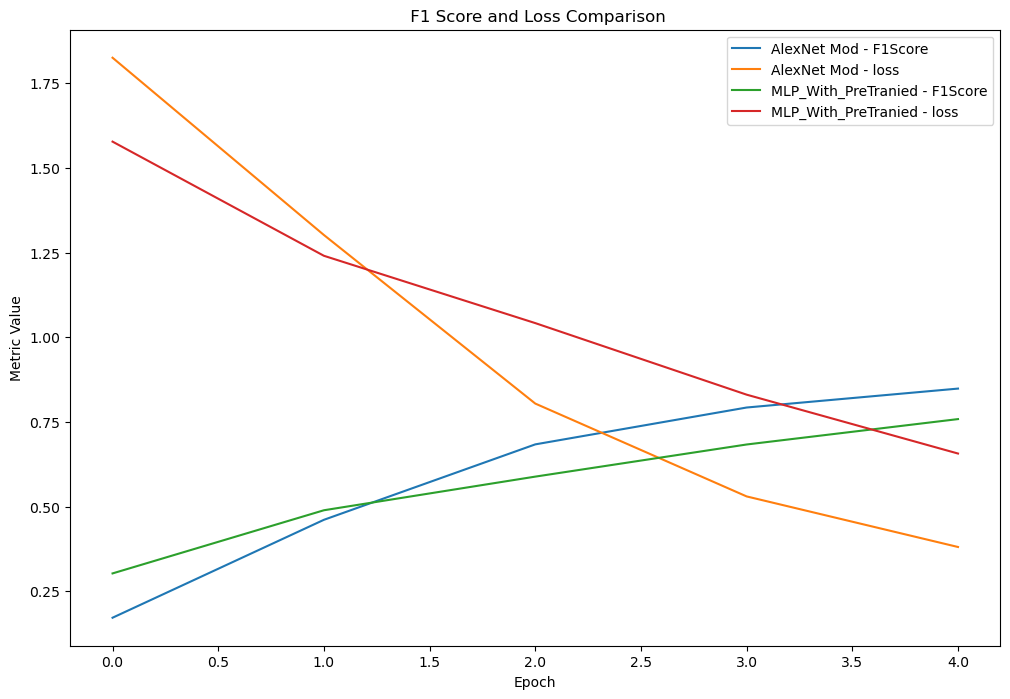

In [68]:
def extract_performance_metrics(histories):
    mean_f1_scores = np.mean([history.history['F1Score'][-1]
                             for history in histories])  # Assuming the last epoch's score
    mean_losses = np.mean([h.history['loss'][-1] for h in histories])
    return mean_f1_scores, mean_losses

vgg16_model_f1, vgg16_model_loss = extract_performance_metrics(vgg16_history_list)
best_cnn_f1, best_cnn_loss = extract_performance_metrics(alexnet_mod_list)


def plot_metrics(models, metrics, title):
    plt.figure(figsize=(12, 8))
    for model_name, model_histories in models.items():
        for metric in metrics:
            means = [np.mean(history.history.get(metric, [0]))
                     for history in model_histories]
            plt.plot(means, label=f'{model_name} - {metric}')

    plt.title(title)
    plt.ylabel('Metric Value')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


# Define your models and their histories
model_histories = {
    'AlexNet Mod': alexnet_mod_list,
    'MLP_With_PreTranied': vgg16_history_list
}

# Plot F1 Scores and Losses
plot_metrics(model_histories, ['F1Score', 'loss'],
             ' F1 Score and Loss Comparison')

Call plot_roc_curve() to compare the performance models

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step
AlexNet Mod - Average AUC Score: 0.9981, Average F1 Score: 0.9467
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step
MLP_With_PreTranied - Average AUC Score: 0.9829, Average F1 Score: 0.8049


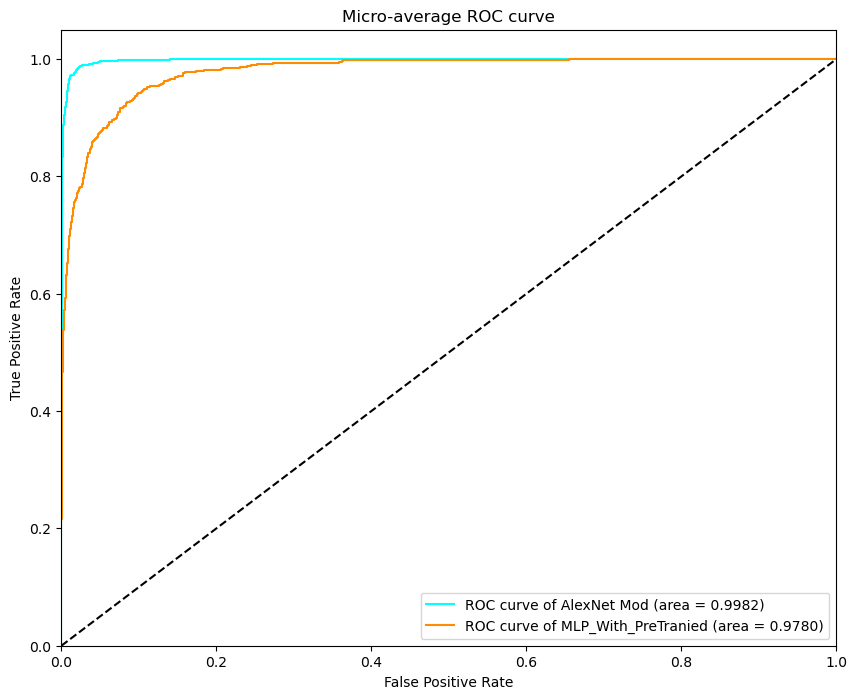

In [69]:
models = [alexnet_1, vgg16_model]
model_names = ['AlexNet Mod', 'MLP_With_PreTranied']
plot_roc_curve(models, model_names, X_test, y_test, num_classes)

##### Compared to the performance of a standard MLP in section 2.4, applying pre-trained models to preprocess the data before feeding it into the MLP has significant improvement in both the F1 score and ROC.

VGG16 is well-regarded for its ability to learn robust features due to its deep architecture and the large variety of images in the ImageNet dataset it was trained on. It's expected to perform well due to these pre-trained features.  
- Effectiveness: The pre-trained VGG16 model is likely to perform the best due to its depth and pre-learned features on a comprehensive dataset like ImageNet.
- Training Efficiency: VGG16 will be slower to train despite freezing the base layers because of its depth. Ensemble models might take longer due to the multiple branches being trained.

However, it seems that our model combining pre-trained models like AlexNet with additional pre-trained layers or features demonstrates lower ROC values and F1 scores. This may be because AlexNet performs better with the current dataset on its own. Furthermore, we could also apply PCA to the dataset to see if it enhances performance.


References:

- Kaggle. Car Images Dataset.https://www.kaggle.com/datasets/kshitij192/cars-image-datasetresource=download (Accessed 2-14-2024)


- Michael Abebe Berwo, et. al. "Deep Learning Techniques for Vehicle Detection and Classification from Images/Videos: A Survey" Sensors 2023, 23(10), 4832; https://doi.org/10.3390/s23104832


- Sumeyra Tas, et. al. "Deep Learning-Based Vehicle Classification for Low Quality Images" Sensors 2022, 22(13), 4740; https://doi.org/10.3390/s22134740

- Simonyan, K., & Zisserman, A. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. ArXiv. /abs/1409.1556

